In [2]:
import os,sys
sys.path.append('../..')
sys.path.append('../../../gempy-1.16/')
import sandbox.sandbox as sb
#New daniel 
from sb import KinectV2

import gempy as gp
#import gempy_sandbox a   s gpsb
import numpy as np
#from PIL import Image, ImageDraw
import pickle

../..\sandbox\sandbox.py:9: UserWarning: Freenect is not installed. if you are using the Kinect Version 2 on a windows machine, use the KinectV2 class!
  warn('Freenect is not installed. if you are using the Kinect Version 2 on a windows machine, use the KinectV2 class!')
../../../gempy-1.16\gempy\plotting\visualization.py:31: UserWarning: Vtk package is not installed. No vtk visualization available.
  warnings.warn('Vtk package is not installed. No vtk visualization available.')
../../../gempy-1.16\gempy\plotting\visualization.py:36: UserWarning: Steno 3D package is not installed. No 3D online visualization available.
  warnings.warn('Steno 3D package is not installed. No 3D online visualization available.')
../../../gempy-1.16\gempy\data_management.py:34: UserWarning: qgrid package is not installed. No interactive dataframes available.
  warnings.warn('qgrid package is not installed. No interactive dataframes available.')
../../../gempy-1.16\gempy\topology.py:28: UserWarning: skimage

### Set up the sandbox 

First we activate the kinect

In [3]:
kinect = sb.KinectV2()

Now we can set up the projector settings:

In [4]:
projector = sb.Projector(resolution = (1024,768), work_directory='./temp',
                        refresh=100, input_rescale=False)

Next is to pass the calibration---kinect-projector---to the projector class to be able to project just on the sandbox.

In [5]:
calibration_filename = "sandbox_test.dat" 
calibration = sb.Calibration(projector)
calibration.load(calibration_file=calibration_filename)
projector.set_calibration(calibration)
projector.start_stream()   

Also we need to set up the general options of Matplotlib (the library to create the models). Here we are passing the colors of GemPy simply for consistency.

In [6]:
plot_im = sb.Plot(
    calibration=calibration,
    cmap=gp.plotting.colors.cmap,
    norm=gp.plotting.colors.norm
    )

### Setup the model gempy model

Now we need to generate the map that we want to poject. In the case of a geological map we will use GemPy.

First we need to load the underlaying 3D model. We can find some examples in the GemPy library

In [7]:
geo_model = gp.read_pickle(r'./../../../gempy-1.16/notebooks/examples/Gempy Modelle Lisa/lisa-7.pickle')

AttributeError: ('The following error happened while compiling the node', Elemwise{add,no_inplace}(<TensorType(int64, scalar)>, TensorConstant{1}), '\n', "module 'numpy.core.multiarray' has no attribute '_get_ndarray_c_version'")

We want to scale the sandbox next to the model extent. We can see a gempy model extent by

In [7]:
geo_model._geo_data.extent

array([   0, 2000,    0, 2000,    0, 1600])

You can just pass those values. However the maximum high of the sandbox may to be to high. If that is the case you can just translate the whole extent up and down by changing the z values (i.e. the last two components of the extent)

### Create sandbox grid following the right scale sandbox-model

Now we need to connect the cloud of points recorded by the kinect to the scale of geological model

In [8]:
scale=sb.Scale(extent=[   0, 2000,    0, 2000,    500, 2500], calibration=calibration) #initialize scale object to handle the scaling of the model in the andbox
scale.calculate_scales()
grid = sb.Grid(calibration=calibration,scale=scale)

Aspect ratio of the model is fixed in XY
Model size is limited by Y dimension
scale in Model units/ mm (X,Y,Z): [2.656891495601173, 2.666666666666667, 4.0]
the shown extent is [0.0, 2651.026392961877, 0.0, 1994.134897360704] 


### Create the GeoMap module for the Sandbox

To increase the flexibility of the sandbox and generalize the hyperthreading (i.e. getting the sandbox running without blocking python), we have create a modules systems. This modules are classes that encapsulate the specific functionality for each type of map that we want to render. Lets create the geological map module.

The work_directory in this class is where we write the image of the geological map. Therefore is **important that it is pointing to same place as the projector class**---which renders the image in the projector.

In [9]:
geo_module = sb.GeoMapModule(geo_model, grid, plot_im,
                             work_directory=projector.work_directory)

This box is not necessary but it is good to test that the model gets computed without any error. If nothing is broken, you are good to go:

In [10]:
geo_module.render_geo_map(*geo_module.compute_model(kinect.get_filtered_frame()))

/home/sarndbox/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


### Hyperthreading

Hyperthreading is important not to block the python script once the sandbox is activated. Later we will show some things we can change while the model is running.

In [11]:
# This will create the threading object which contains the functionality related to the thread itself
s_thread = sb.SandboxThread(geo_module, kinect, projector)

Running the thread we will initialize the real-time updating in the sandbox. If you have made it up to here you have done most of the work.

In [12]:
s_thread.run()

**Congratulations your Sandbox (should be) is running!!**
<hr style='border-width: 6px'>


Now if you want to stop the thread you can do it by calling next cell. (By default we leave it commented just delete the Hashtag)

In [13]:
# s_thread.kill()

## Real time-manipulation

Now that the hyperthreading is on, we can do couple of cool things. Most of the code from here on is written under the 

```python
with s_thread.lock:
    ...
```

This is to guarantee that one thread is not messing with the other. Lets start to see what good stuff can we do

#### Show/hide topography

In [14]:
with s_thread.lock:
    geo_module.plot_topography = True

#### Show/hide faults

In [15]:
with s_thread.lock:
    geo_module.plot_faults = False

#### Moving the extent:

In [29]:
with s_thread.lock:
    scale.extent = [0, 2000,    0, 2000,   1000, 2500]
    scale.calculate_scales()

Aspect ratio of the model is fixed in XY
Model size is limited by Y dimension
scale in Model units/ mm (X,Y,Z): [2.656891495601173, 2.666666666666667, 4.0]


#### Save geological/topology map
(Okay these two work sometimes work better if you kill the thread first)

In [16]:
with s_thread.lock:
    geo_module.export_geological_map(kinect.get_filtered_frame(),
                                     'geological_map.pdf')

there is still a bug in the map that causes the uppermost lithology to be displayed in the basement color. Unfortunately we do not have a quick fix for this currently... Sorry! Please fix the map yourself, for example using illustrator


In [19]:
with s_thread.lock:
    geo_module.export_topographic_map('topographic_map.pdf')

/home/sarndbox/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/sarndbox/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/sarndbox/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/sarndbox/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/sarndbox/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/sarndbox/anaconda3/lib/python

#### change contour levels 

In [22]:
with s_thread.lock:
    geo_module.create_sub_contours(0,2000,step=50)

### Loading GemPy models and use GemPy functionality

This is a big one. Since the  thread is free we can still use gempy. The main thing to keep in ming is **not to use the same name for the variable when you load a new model**. Otherwise you risk to mixing which variable is which model and where it is.

For example we can visualize the model by reading it again:

In [23]:
geo_model_grab = gp.read_pickle(r'./../../../gempy/notebooks/examples/Models_Lisa/lisa-7.pickle')

Computing it:

In [25]:
with s_thread.lock:
    l, f = gp.compute_model(geo_model_grab)


And plotting it:

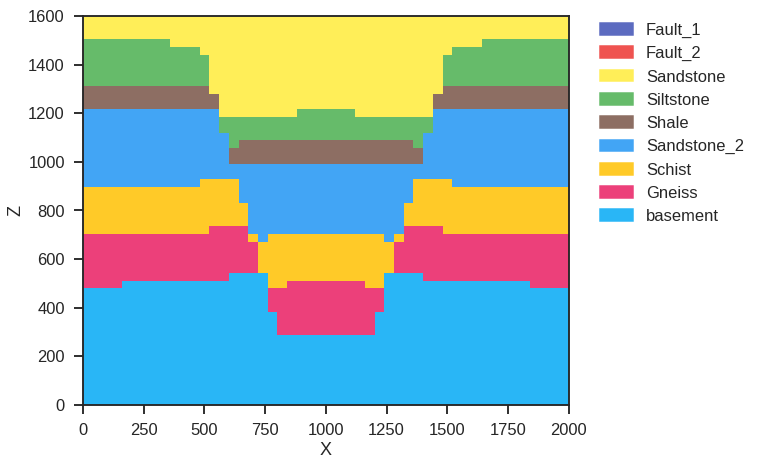

In [26]:
with s_thread.lock:
    gp.plotting.plot_section(geo_model_grab._geo_data, l[0], 25)

### Finally we can swap models as well!

In the same fashion that we have imported the same model to visualize the section, we can load another model and swap it. **Be careful about the extent** if the second model has a different exntent you may be projecting the wrong area:

In [28]:
geo_model_swap= gp.read_pickle(r'./../../../gempy/notebooks/examples/Models_Lisa/lisa-3.pickle')

/home/sarndbox/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


In [30]:
with s_thread.lock:
    # The names choice is aweful. In new iteration we will use better the alphabet
    geo_module.geo_model = geo_model_swap

In [31]:
geo_model_swap.potential_at_interfaces

array([[40.965733, 40.924774, 40.82238 , 40.760944, 40.638073, 40.355465]],
      dtype=float32)

In [32]:
geo_model_swap.geo_data_res.n_faults

0